# Mini-Project: W8_D5

## Meta-Analysis of Research Papers on Large Language Models (LLMs)

# Mini Project - Meta-Analysis of Research Papers on Large Language Models (LLMs)

## What You'll Learn

- How to critically read and evaluate multiple LLM research papers.  
- How to compare methodologies, architectures, and findings across studies.  
- How to synthesize insights and trends in current LLM research.  
- How to structure a scientific meta-analysis report in deep learning.  

## What You Will Create

A written report (PDF) that analyzes **3 to 5 recent research papers** on LLMs.  
The report will highlight **key contributions**, **compare methodologies**, and **identify common challenges and future research directions**.

---

## Task

You will conduct a **meta-analysis** of **3 to 5 research papers** related to Large Language Models (LLMs).  
Your task is **not just to summarize** each paper, but to **analyze and synthesize** their contributions, differences, similarities, and limitations.

Your final output should be a **well-structured PDF report** (maximum 6 pages), written in your own words, with the following sections:

---

### 1. Introduction
- Briefly introduce LLMs and explain the goal of your meta-analysis.  
- Describe the theme/topic connecting your selected papers (e.g., instruction tuning, model efficiency, alignment, etc.).  
- List the titles and publication sources of the papers.  

### 2. Paper Summaries
For each paper (3 to 5 total):  
- Provide the full citation (author, year, title, venue).  
- Summarize the research problem, proposed solution, and main results.  
- Mention datasets used, model architecture, and evaluation metrics.  

### 3. Comparative Analysis
Compare the papers across key aspects such as:  
- Objectives and problem domains  
- Model architectures and innovations  
- Training or fine-tuning strategies  
- Benchmarks and evaluation  
- Strengths, limitations, and reproducibility  

You may use **tables** or **charts** to support your comparison.

### 4. Insights and Reflection
- What trends or patterns emerge across the papers?  
- Which methods or approaches seem most promising or innovative?  
- What limitations or challenges are commonly acknowledged?  
- What are potential future directions in this research area?  

### 5. Conclusion
Summarize the key findings from your meta-analysis and reflect on how the field is evolving.

---

## Submission Instructions

**Push your report to GitHub**, including:
- The final PDF report (`meta_analysis_llms.pdf`)  
- A `README.md` file listing the papers used with links to each  
- Any supporting tables or visualizations (optional)  

## Colab — Drive Persistence Helper (mount + sync papers/)

In [1]:
# Titles: "Colab — Drive Persistence Helper (mount + sync papers/)"
# Purpose:
# - Mount Google Drive
# - Define a persistent project folder in Drive
# - Auto-restore papers/ after runtime restarts
# - Auto-save back to Drive at the end via save_to_drive()

from google.colab import drive  # type: ignore
import os, shutil
from pathlib import Path

# 0.1) Mount Drive
drive.mount('/content/drive')

# 0.2) Configure persistent dirs (Drive ↔ Local)
DRIVE_PROJECT_ROOT = Path('/content/drive/MyDrive/llm_meta_analysis')
DRIVE_PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

LOCAL_PROJECT_ROOT = Path('/content/llm_meta_analysis')
LOCAL_PROJECT_ROOT.mkdir(parents=True, exist_ok=True)

PERSIST_FOLDERS = [
    'papers',           # PDFs, metadata, README
    'papers/extracted', # Step 2 outputs
]

def copy_dir(src: Path, dst: Path):
    """Recursively copy src directory into dst (creates dst if needed)."""
    src = Path(src); dst = Path(dst)
    if not src.exists():
        return
    dst.mkdir(parents=True, exist_ok=True)
    for root, dirs, files in os.walk(src):
        rel = Path(root).relative_to(src)
        (dst / rel).mkdir(parents=True, exist_ok=True)
        for f in files:
            s = Path(root) / f
            d = (dst / rel) / f
            # Cheap dedupe: skip if same size
            if d.exists() and d.stat().st_size == s.stat().st_size:
                continue
            shutil.copy2(s, d)

# 0.3) Restore from Drive → Local
for sub in PERSIST_FOLDERS:
    drive_path = DRIVE_PROJECT_ROOT / sub
    local_path = LOCAL_PROJECT_ROOT / sub
    if drive_path.exists():
        print(f"[RESTORE] {drive_path} → {local_path}")
        copy_dir(drive_path, local_path)
    else:
        print(f"[INIT] Create {drive_path}")
        drive_path.mkdir(parents=True, exist_ok=True)

# 0.4) Switch working dir to Local
os.chdir(LOCAL_PROJECT_ROOT)
print(f"Working directory set to: {Path.cwd()}")

# 0.5) Save helper (Local → Drive)
def save_to_drive():
    """Copy all PERSIST_FOLDERS from Local → Drive."""
    for sub in PERSIST_FOLDERS:
        local_path = LOCAL_PROJECT_ROOT / sub
        drive_path = DRIVE_PROJECT_ROOT / sub
        if local_path.exists():
            print(f"[SAVE] {local_path} → {drive_path}")
            copy_dir(local_path, drive_path)
        else:
            print(f"[SKIP] {local_path} does not exist.")
    print("[DONE] Saved to Drive.")

print("Hint: call save_to_drive() at the end of Step 1 / Step 2 to persist outputs.")

Mounted at /content/drive
[RESTORE] /content/drive/MyDrive/llm_meta_analysis/papers → /content/llm_meta_analysis/papers
[RESTORE] /content/drive/MyDrive/llm_meta_analysis/papers/extracted → /content/llm_meta_analysis/papers/extracted
Working directory set to: /content/llm_meta_analysis
Hint: call save_to_drive() at the end of Step 1 / Step 2 to persist outputs.


## Environment Setup

In [2]:
# Title: "Environment Setup"
# Install only what is required for this notebook.

!pip -q install arxiv pandas tqdm python-dateutil pymupdf==1.24.10 transformers sentencepiece accelerate >/dev/null

## Step 1 — Search arXiv & Select Top-K

In [3]:
# Title: "Step 1 — Search arXiv & Select Top-K"
# Notes (English):
# - Use arxiv.Client() (new API) to avoid deprecation warnings.
# - Rank by a simple heuristic: keywords + recency + category bonus.
# - Save metadata CSV for later steps.

from datetime import datetime, timezone
from dateutil import parser as dateparser
from IPython.display import display
import arxiv
import pandas as pd
import re
from pathlib import Path

# 2.1) Config
QUERY = '"instruction tuning" OR "preference optimization" OR "alignment" OR (LLM AND evaluation)'
CATEGORIES = ["cs.CL", "cs.LG"]   # target categories
MAX_CANDIDATES = 40               # search breadth
TOP_K = 5                         # final selection (3–5 recommended)
DATE_FROM = "2024-01-01"
DATE_TO = datetime.now(timezone.utc).strftime("%Y-%m-%d")

SAVE_DIR = Path("papers")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# 2.2) Helpers
def clean_text(s: str) -> str:
    """Basic cleanup: collapse whitespace and strip."""
    if not s:
        return ""
    return re.sub(r"\s+", " ", s).strip()

def get_category_terms(entry) -> list[str]:
    """
    Normalize categories to list[str] across arxiv lib versions.
    Supports list[str] and list[objects with .term].
    """
    cats = getattr(entry, "categories", None)
    if not cats:
        return []
    out = []
    for c in cats:
        t = getattr(c, "term", None)
        out.append(t if t is not None else str(c))
    return out

def heuristic_score(entry) -> float:
    """
    Combine keyword hits, recency, and category bonus into a simple score.
    """
    title = (getattr(entry, "title", "") or "").lower()
    summary = (getattr(entry, "summary", "") or "").lower()
    text = f"{title} {summary}"

    kw = {
        "instruction": 2.0, "tuning": 2.0, "instruction tuning": 3.0,
        "preference": 1.5, "dpo": 2.5, "ppo": 2.0,
        "alignment": 1.5, "evaluat": 1.2,
        "benchmark": 1.0, "sft": 1.5,
    }
    score = sum(w for k, w in kw.items() if k in text)

    published = getattr(entry, "published", None) or getattr(entry, "updated", None)
    if published:
        days = (datetime.now(timezone.utc) - published).days
        recency = max(0.0, 1.0 - days / 365.0)      # 0..1
        score += 2.0 * recency

    if any(term in CATEGORIES for term in get_category_terms(entry)):
        score += 0.5
    return score

# 2.3) Query arXiv (new Client API)
client = arxiv.Client()
search = arxiv.Search(
    query=QUERY,
    max_results=MAX_CANDIDATES,
    sort_by=arxiv.SortCriterion.SubmittedDate,
    sort_order=arxiv.SortOrder.Descending,
)

candidates = []
for result in client.results(search):
    pub_dt = result.published or result.updated
    if not pub_dt:
        continue
    if pub_dt.date() < dateparser.parse(DATE_FROM).date():  # min date
        continue
    if pub_dt.date() > dateparser.parse(DATE_TO).date():    # max date
        continue
    candidates.append(result)

print(f"Found {len(candidates)} recent candidates.")

# 2.4) Rank and select Top-K
scored = sorted(((heuristic_score(r), r) for r in candidates), key=lambda x: x[0], reverse=True)
selected = [r for _, r in scored[:TOP_K]]

# 2.5) Build metadata rows
rows = []
for r in selected:
    authors = ", ".join(a.name for a in (getattr(r, "authors", []) or []))
    pdf_url = getattr(r, "pdf_url", None)
    if not pdf_url:
        entry_id = getattr(r, "entry_id", "")
        if entry_id:
            pdf_url = re.sub(r"/abs/", "/pdf/", entry_id) + ".pdf"

    cats = get_category_terms(r)
    primary_cat = getattr(r, "primary_category", "")
    if hasattr(primary_cat, "term"):
        primary_cat = primary_cat.term

    rows.append({
        "arxiv_id": getattr(r, "entry_id", ""),
        "title": clean_text(getattr(r, "title", "")),
        "authors": authors,
        "published": (getattr(r, "published", None) or getattr(r, "updated", None)).strftime("%Y-%m-%d"),
        "primary_category": primary_cat,
        "categories": ", ".join(cats),
        "summary": clean_text(getattr(r, "summary", "")),
        "pdf_url": pdf_url,
        "comment": getattr(r, "comment", ""),
        "journal_ref": getattr(r, "journal_ref", ""),
        "doi": getattr(r, "doi", ""),
    })

meta_df = pd.DataFrame(rows)
meta_csv_path = SAVE_DIR / "selected_papers_metadata.csv"
meta_df.to_csv(meta_csv_path, index=False)
print(f"[OK] Saved metadata CSV → {meta_csv_path.resolve()}")
display(meta_df.head(2))

Found 40 recent candidates.
[OK] Saved metadata CSV → /content/llm_meta_analysis/papers/selected_papers_metadata.csv


,arxiv_id,title,authors,published,primary_category,categories,summary,pdf_url,comment,journal_ref,doi
0,http://arxiv.org/abs/2508.05496v1,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025-08-07,cs.AI,cs.AI,Large language models (LLMs) have exhibited im...,http://arxiv.org/pdf/2508.05496v1,None,None,None
1,http://arxiv.org/abs/2508.05635v1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025-08-07,cs.RO,"cs.RO, cs.CV","We introduce Genie Envisioner (GE), a unified ...",http://arxiv.org/pdf/2508.05635v1,https://genie-envisioner.github.io/,None,None


## Step 1 — Download PDFs

In [4]:
# Title: "Step 1 — Download PDFs"
# Notes:
# - Stream-download with retries and a minimal PDF sanity check.

import time
import requests
from pathlib import Path

def is_probably_pdf(path: Path) -> bool:
    """Minimal sanity check: non-empty file and starts with %PDF."""
    try:
        if not path.exists() or path.stat().st_size < 1024:
            return False
        with open(path, "rb") as f:
            head = f.read(5)
        return head.startswith(b"%PDF")
    except Exception:
        return False

def download_file(url: str, out_path: Path, max_retries: int = 3, backoff: float = 2.0) -> bool:
    """Stream-download with basic retries and exponential backoff."""
    for attempt in range(1, max_retries + 1):
        try:
            with requests.get(url, stream=True, timeout=60) as r:
                r.raise_for_status()
                with open(out_path, "wb") as f:
                    for chunk in r.iter_content(chunk_size=8192):
                        if chunk:
                            f.write(chunk)
            if is_probably_pdf(out_path):
                return True
            else:
                print(f"[WARN] Failed PDF check: {out_path.name}")
        except Exception as e:
            print(f"[WARN] Attempt {attempt}/{max_retries} failed: {e}")
        time.sleep(backoff * attempt)
    return False

# Build names and download
pdf_paths, failures = [], []
for i, row in meta_df.iterrows():
    title = row.get("title", f"paper_{i+1}")
    pdf_url = row.get("pdf_url", "")
    if not pdf_url:
        print(f"[SKIP] No PDF URL for row {i+1} — {title}")
        continue
    title_safe = re.sub(r"[^a-zA-Z0-9_-]+", "_", title)[:120]
    out_path = SAVE_DIR / f"{i+1:02d}_{title_safe}.pdf"
    ok = download_file(pdf_url, out_path)
    if ok:
        pdf_paths.append(str(out_path.resolve()))
        print(f"[OK] {out_path.name}")
    else:
        failures.append((title, pdf_url))
        print(f"[FAIL] {title} — {pdf_url}")

print("\nSummary:")
print(f"  Successful PDFs: {len(pdf_paths)}")
print(f"  Failed: {len(failures)}")
if failures:
    for t, u in failures:
        print(f"   - {t} — {u}")

[OK] 01_InfiAlign_A_Scalable_and_Sample-Efficient_Framework_for_Aligning_LLMs_to_Enhance_Reasoning_Capabilities.pdf
[OK] 02_Genie_Envisioner_A_Unified_World_Foundation_Platform_for_Robotic_Manipulation.pdf
[OK] 03_Hi3DEval_Advancing_3D_Generation_Evaluation_with_Hierarchical_Validity.pdf
[OK] 04_Do_Political_Opinions_Transfer_Between_Western_Languages_An_Analysis_of_Unaligned_and_Aligned_Multilingual_LLMs.pdf
[OK] 05_RankArena_A_Unified_Platform_for_Evaluating_Retrieval_Reranking_and_RAG_with_Human_and_LLM_Feedback.pdf

Summary:
  Successful PDFs: 5
  Failed: 0


## Step 1 — Generate README.md

In [5]:
# Title: "Step 1 — Generate README.md"
# Notes:
# - Handy for GitHub submission and quick reference.

readme_path = SAVE_DIR / "README.md"
with open(readme_path, "w", encoding="utf-8") as f:
    f.write("# Selected Papers for LLM Meta-Analysis\n\n")
    f.write(f"Query used: `{QUERY}`\n\n")
    f.write("## Papers\n\n")
    for _, row in meta_df.iterrows():
        title = row["title"]; authors = row["authors"]; date = row["published"]
        link = row["arxiv_id"]; pdf = row["pdf_url"]
        f.write(f"- **{title}** ({date}) — {authors}\n")
        f.write(f"  - Abstract: {link}\n")
        f.write(f"  - PDF: {pdf}\n\n")

print(f"[OK] README generated → {readme_path.resolve()}")
print("NEXT: run save_to_drive() if you want to persist Step 1 outputs now.")

[OK] README generated → /content/llm_meta_analysis/papers/README.md
NEXT: run save_to_drive() if you want to persist Step 1 outputs now.


## Step 2 — Structured PDF Extraction

In [6]:
# Title: "Step 2 — Structured PDF Extraction"
# Notes:
# - Parse PDFs → sections; optionally summarize with a local HF model (FLAN-T5).
# - Save structured rows to CSV/JSONL.

import os, re, json
from pathlib import Path
import pandas as pd
from tqdm import tqdm
import fitz  # PyMuPDF

# 3.1) Optional local Hugging Face summarization (GPU recommended)
USE_LOCAL_HF = True                    # Toggle this to False to skip model summarization
HF_MODEL_NAME = "google/flan-t5-base"  # Try flan-t5-large on a strong GPU

if USE_LOCAL_HF:
    from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
    import torch
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    tokenizer = AutoTokenizer.from_pretrained(HF_MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(HF_MODEL_NAME).to(device)

# 3.2) Paths & metadata
PAPERS_DIR = Path("papers")
META_CSV = PAPERS_DIR / "selected_papers_metadata.csv"
OUT_DIR = PAPERS_DIR / "extracted"
SECTIONS_DIR = OUT_DIR / "sections_raw"
OUT_DIR.mkdir(parents=True, exist_ok=True)
SECTIONS_DIR.mkdir(parents=True, exist_ok=True)
assert META_CSV.exists(), "Metadata CSV not found. Please complete Step 1."
meta_df = pd.read_csv(META_CSV)

# 3.3) Text extraction + light cleaning
def extract_pdf_text(pdf_path: Path) -> str:
    """Extract plain text from a PDF using PyMuPDF and lightly clean noise."""
    parts = []
    with fitz.open(pdf_path) as doc:
        for page in doc:
            parts.append(page.get_text("text"))
    text = "\n\n".join(parts)
    text = re.sub(r"\s+", " ", text).strip()

    # Cut tails at common sections (References, Appendix, etc.)
    cut_patterns = [r"\breferences\b", r"\bbibliography\b", r"\backnowledg(e)?ments\b", r"\bappendix\b"]
    cut_pos = len(text)
    for pat in cut_patterns:
        m = re.search(pat, text, flags=re.IGNORECASE)
        if m:
            cut_pos = min(cut_pos, m.start())
    text = text[:cut_pos]

    # Remove bracketed numeric citations like [12] or [3, 7]
    text = re.sub(r"\[\s*\d+(?:\s*,\s*\d+)*\s*\]", "", text)

    # Remove date ranges like (2013–2014)
    text = re.sub(r"\(\s*\d{4}\s*[–-]\s*\d{4}\s*\)", "", text)

    # Remove arXiv IDs
    text = re.sub(r"arXiv:\s*\d{4}\.\d{4,5}(?:v\d+)?", "", text, flags=re.IGNORECASE)

    # Normalize spaces
    return re.sub(r"\s+", " ", text).strip()

# 3.4) Heuristic section splitter
SECTION_PATTERNS = [
    ("abstract", r"\babstract\b"),
    ("introduction", r"\bintroduction\b"),
    ("method", r"\bmethod(s)?\b|\bapproach\b|\bmodel\b"),
    ("results", r"\bresults?\b|\bevaluation\b|\bmetrics\b|\bbenchmark\b"),
    ("datasets", r"\bdatasets?\b|\bdata\b"),
    ("conclusion", r"\bconclusion(s)?\b|\bdiscussion\b|\blimitation(s)?\b"),
]

def split_into_sections(text: str) -> dict:
    anchors = []
    for key, pat in SECTION_PATTERNS:
        for m in re.finditer(pat, text, flags=re.IGNORECASE):
            anchors.append((m.start(), key))
    if not anchors:
        return {"body": text}
    anchors.sort(key=lambda x: x[0])
    sections = {}
    for i, (start_idx, key) in enumerate(anchors):
        end_idx = anchors[i + 1][0] if i + 1 < len(anchors) else len(text)
        sections[key] = text[start_idx:end_idx].strip()
    return sections

# 3.5) Optional HF summarize → structured JSON
SUMMARY_PROMPT = (
    "Extract a concise JSON with keys: research_problem, proposed_solution, main_results, "
    "datasets, model_architecture, evaluation_metrics. Short phrases only. If unknown, use ''.\n\nPaper content:\n"
)
JSON_KEYS = ["research_problem","proposed_solution","main_results","datasets","model_architecture","evaluation_metrics"]

def hf_summarize_to_json(text: str) -> dict:
    """Call local HF model (if enabled) to produce a small JSON snippet."""
    if not USE_LOCAL_HF:
        return {k: "" for k in JSON_KEYS}
    snippet = text[:5000]
    prompt = SUMMARY_PROMPT + snippet + "\n\nReturn JSON only."
    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=1024).to(model.device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_new_tokens=256, do_sample=False)
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    try:
        m = re.search(r"\{.*\}", decoded, flags=re.DOTALL)
        data = json.loads(m.group(0)) if m else {}
        return {k: str(data.get(k, "")).strip() for k in JSON_KEYS}
    except Exception:
        return {k: "" for k in JSON_KEYS}

def postprocess_field(s: str) -> str:
    """Trim, drop citation brackets, strip 'Abstract' prefix, cap length."""
    if not s:
        return ""
    s = re.sub(r"\s+", " ", str(s)).strip()
    s = re.sub(r"\[\s*\d+(?:\s*,\s*\d+)*\s*\]", "", s)
    s = re.sub(r"^\s*Abstract\s*", "", s, flags=re.IGNORECASE)
    return s[:600]

def fix_hyphenation(s: str) -> str:
    """Join words split by hyphen at line breaks and normalize spaces."""
    if not isinstance(s, str):
        return ""
    s = re.sub(r"-\s+", "", s)
    return re.sub(r"\s+", " ", s).strip()

# 3.6) Process PDFs
rows = []
for i, meta in tqdm(list(meta_df.iterrows()), desc="Processing PDFs"):
    title = meta.get("title", f"paper_{i+1}")
    authors = meta.get("authors", "")
    published = meta.get("published", "")
    arxiv_id = meta.get("arxiv_id", "")
    journal_ref = str(meta.get("journal_ref", "")).strip()
    venue = journal_ref if journal_ref and journal_ref.lower() != "nan" else "arXiv"

    pdf_path = next(PAPERS_DIR.glob(f"{i+1:02d}_*.pdf"), None)
    if not pdf_path:
        print(f"[WARN] PDF not found for row {i+1}: {title}")
        continue

    full_text = extract_pdf_text(pdf_path)
    sections = split_into_sections(full_text)

    with open(SECTIONS_DIR / f"{i+1:02d}_sections.json", "w", encoding="utf-8") as f:
        json.dump(sections, f, ensure_ascii=False, indent=2)

    context = "\n\n".join([
        sections.get("abstract", "")[:1200],
        sections.get("method", "")[:1200],
        sections.get("results", "")[:1200],
        sections.get("introduction", "")[:800],
    ])[:4500]
    model_json = hf_summarize_to_json(context)

    abstract = sections.get("abstract", "")
    intro = sections.get("introduction", "")
    method = sections.get("method", "")
    results = sections.get("results", "")
    datasets = sections.get("datasets", "")

    DATASET_KWS = [
        "MMLU","GSM8K","HumanEval","MBPP","ARC","HellaSwag","TruthfulQA","BBH","SQuAD","MNLI",
        "BoolQ","Winogrande","PIQA","COCO","ImageNet","MIRACL","Natural Questions","HotpotQA",
        "TriviaQA","DROP","OpenBookQA","WMT","SuperGLUE","GLUE","MATH"
    ]
    METRIC_KWS = ["accuracy","acc","f1","f-1","precision","recall","rouge","bleu","meteor","exact match","em","ndcg","mrr","map"]

    def _extract_keywords(text, vocab):
        low = text.lower()
        return ", ".join(sorted({kw for kw in vocab if kw.lower() in low}))

    datasets_auto = model_json.get("datasets") or _extract_keywords(" ".join([datasets, results, method]), DATASET_KWS)
    metrics_auto  = model_json.get("evaluation_metrics") or _extract_keywords(results, METRIC_KWS)

    def pick(*cands):
        for c in cands:
            if c and len(c.split()) > 5:
                return re.sub(r"\s+", " ", c).strip()[:600]
        return ""

    structured = {
        "title": title,
        "authors": authors,
        "year": str(published)[:4] if str(published) else "",
        "venue": venue,
        "research_problem": postprocess_field(model_json.get("research_problem") or pick(abstract, intro)),
        "proposed_solution": postprocess_field(model_json.get("proposed_solution") or pick(method, intro)),
        "main_results": postprocess_field(model_json.get("main_results") or pick(results)),
        "datasets": postprocess_field(datasets_auto),
        "model_architecture": postprocess_field(model_json.get("model_architecture") or pick(method)),
        "evaluation_metrics": postprocess_field(metrics_auto),
        "source_pdf": str(pdf_path),
        "arxiv_id": arxiv_id,
    }
    # Fix hyphenation on key fields
    for k in ["research_problem","proposed_solution","main_results","datasets","model_architecture","evaluation_metrics"]:
        structured[k] = fix_hyphenation(structured[k])

    rows.append(structured)

# 3.7) Save structured outputs
STRUCT_CSV = OUT_DIR / "structured_extraction.csv"
STRUCT_JSONL = OUT_DIR / "structured_extraction.jsonl"

struct_df = pd.DataFrame(rows)
struct_df.to_csv(STRUCT_CSV, index=False)
with open(STRUCT_JSONL, "w", encoding="utf-8") as f:
    for r in rows:
        f.write(json.dumps(r, ensure_ascii=False) + "\n")

print(f"[OK] Saved → {STRUCT_CSV}")
print(f"[OK] Saved → {STRUCT_JSONL}")
display(struct_df.head())

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Processing PDFs: 100%|██████████| 5/5 [00:04<00:00,  1.02it/s]

[OK] Saved → papers/extracted/structured_extraction.csv
[OK] Saved → papers/extracted/structured_extraction.jsonl


,title,authors,year,venue,research_problem,proposed_solution,main_results,datasets,model_architecture,evaluation_metrics,source_pdf,arxiv_id
0,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025,arXiv,Large language models (LLMs) have exhibited im...,approach integrates both domainlevel and seman...,,,approach integrates both domainlevel and seman...,,papers/01_InfiAlign_A_Scalable_and_Sample-Effi...,http://arxiv.org/abs/2508.05496v1
1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025,arXiv,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","evaluation, and the provision of both robotic ...",,"model, enabling predictive reasoning and plann...",,papers/02_Genie_Envisioner_A_Unified_World_Fou...,http://arxiv.org/abs/2508.05635v1
2,Hi3DEval: Advancing 3D Generation Evaluation w...,"Yuhan Zhang, Long Zhuo, Ziyang Chu, Tong Wu, Z...",2025,arXiv,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...",evaluation pipeline enhances scalability and c...,,"methods, thereby improving generalization. Soc...",,papers/03_Hi3DEval_Advancing_3D_Generation_Eva...,http://arxiv.org/abs/2508.05609v1
3,Do Political Opinions Transfer Between Western...,"Franziska Weeber, Tanise Ceron, Sebastian Padó",2025,arXiv,Public opinion surveys show cross-cultural dif...,"model-inherent political opinions, but opinion...",evaluation framework from Ceron et al. (2024) ...,,"model-inherent political opinions, but opinion...",,papers/04_Do_Political_Opinions_Transfer_Betwe...,http://arxiv.org/abs/2508.05553v1
4,RankArena: A Unified Platform for Evaluating R...,"Abdelrahman Abdallah, Mahmoud Abdalla, Bhawna ...",2025,arXiv,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,results demonstrate a generally strong positiv...,ARC,methods: a small number of rerankers dominate ...,em,papers/05_RankArena_A_Unified_Platform_for_Eva...,http://arxiv.org/abs/2508.05512v1


## Step 2 — Final Tidy Pass (analysis_ready.csv)

In [7]:
# Title: "Step 2 — Final Tidy Pass (analysis_ready.csv)"
# Notes:
# - Ensure datasets/metrics have basic fallbacks.
# - Save analysis_ready.csv for Step 3.

import pandas as pd
from pathlib import Path
import re

df = struct_df.copy().fillna("")

DATASET_KWS = ["MMLU","GSM8K","HumanEval","MBPP","ARC","HellaSwag","TruthfulQA","BBH","SQuAD","MNLI","BoolQ",
               "Winogrande","PIQA","COCO","ImageNet","MIRACL","Natural Questions","HotpotQA","TriviaQA","DROP",
               "OpenBookQA","WMT","SuperGLUE","GLUE","MATH"]
METRIC_KWS = ["accuracy","acc","f1","f-1","precision","recall","rouge","bleu","meteor","exact match","em","ndcg","mrr","map"]

def _extract_keywords(text, vocab):
    low = text.lower()
    return ", ".join(sorted({kw for kw in vocab if kw.lower() in low}))

if "datasets" in df.columns and "main_results" in df.columns and "model_architecture" in df.columns:
    empty_ds = df["datasets"].str.len() < 2
    df.loc[empty_ds, "datasets"] = df.loc[empty_ds].apply(
        lambda r: _extract_keywords(f"{r.get('main_results','')} {r.get('model_architecture','')}", DATASET_KWS), axis=1
    )

if "evaluation_metrics" in df.columns and "main_results" in df.columns:
    empty_mt = df["evaluation_metrics"].str.len() < 2
    df.loc[empty_mt, "evaluation_metrics"] = df.loc[empty_mt, "main_results"].apply(
        lambda t: _extract_keywords(t, METRIC_KWS)
    )

ANALYSIS_CSV = Path("papers/extracted/analysis_ready.csv")
df.to_csv(ANALYSIS_CSV, index=False)
print(f"[OK] analysis_ready.csv saved → {ANALYSIS_CSV.resolve()}")
display(df.head())

[OK] analysis_ready.csv saved → /content/llm_meta_analysis/papers/extracted/analysis_ready.csv


,title,authors,year,venue,research_problem,proposed_solution,main_results,datasets,model_architecture,evaluation_metrics,source_pdf,arxiv_id
0,InfiAlign: A Scalable and Sample-Efficient Fra...,"Shuo Cai, Su Lu, Qi Zhou, Kejing Yang, Zhijie ...",2025,arXiv,Large language models (LLMs) have exhibited im...,approach integrates both domainlevel and seman...,,,approach integrates both domainlevel and seman...,,papers/01_InfiAlign_A_Scalable_and_Sample-Effi...,http://arxiv.org/abs/2508.05496v1
1,Genie Envisioner: A Unified World Foundation P...,"Yue Liao, Pengfei Zhou, Siyuan Huang, Donglin ...",2025,arXiv,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","evaluation, and the provision of both robotic ...",,"model, enabling predictive reasoning and plann...",,papers/02_Genie_Envisioner_A_Unified_World_Fou...,http://arxiv.org/abs/2508.05635v1
2,Hi3DEval: Advancing 3D Generation Evaluation w...,"Yuhan Zhang, Long Zhuo, Ziyang Chu, Tong Wu, Z...",2025,arXiv,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...",evaluation pipeline enhances scalability and c...,,"methods, thereby improving generalization. Soc...",,papers/03_Hi3DEval_Advancing_3D_Generation_Eva...,http://arxiv.org/abs/2508.05609v1
3,Do Political Opinions Transfer Between Western...,"Franziska Weeber, Tanise Ceron, Sebastian Padó",2025,arXiv,Public opinion surveys show cross-cultural dif...,"model-inherent political opinions, but opinion...",evaluation framework from Ceron et al. (2024) ...,,"model-inherent political opinions, but opinion...",,papers/04_Do_Political_Opinions_Transfer_Betwe...,http://arxiv.org/abs/2508.05553v1
4,RankArena: A Unified Platform for Evaluating R...,"Abdelrahman Abdallah, Mahmoud Abdalla, Bhawna ...",2025,arXiv,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,results demonstrate a generally strong positiv...,ARC,methods: a small number of rerankers dominate ...,em,papers/05_RankArena_A_Unified_Platform_for_Eva...,http://arxiv.org/abs/2508.05512v1


## Step 3 — Comparative Analysis (Auto-Enrich + Tables + Charts

[OK] Enriched and saved → papers/extracted/analysis_ready.csv
=== Comparative Table of Selected Papers ===


,title,research_problem,proposed_solution,datasets,evaluation_metrics
0,InfiAlign: A Scalable and Sample-Efficient Fra...,Large language models (LLMs) have exhibited im...,approach integrates both domainlevel and seman...,"InfiAlign, MATH, MMLU","accuracy, correlation, cosine similarity, em, ..."
1,Genie Envisioner: A Unified World Foundation P...,"We introduce Genie Envisioner (GE), a unified ...","model, enabling predictive reasoning and plann...","GE-Act, GE-Base, GE-Sim, Genie","bleu, correlation, cosine similarity, map, mse..."
2,Hi3DEval: Advancing 3D Generation Evaluation w...,shapes. Future work will aim to extend the,"methods, thereby improving generalization. Soc...","DROP, Hi3DEval","accuracy, cosine similarity, em, exact match, ..."
3,Do Political Opinions Transfer Between Western...,Public opinion surveys show cross-cultural dif...,"model-inherent political opinions, but opinion...","DROP, WMT","agreement, nan"
4,RankArena: A Unified Platform for Evaluating R...,Evaluating the quality of retrieval-augmented ...,methods: a small number of rerankers dominate ...,"ARC, BEIR, MS MARCO, RankArena, TREC","agreement, correlation, em"


[OK] Comparative table saved → /content/llm_meta_analysis/papers/extracted/comparative_table.csv


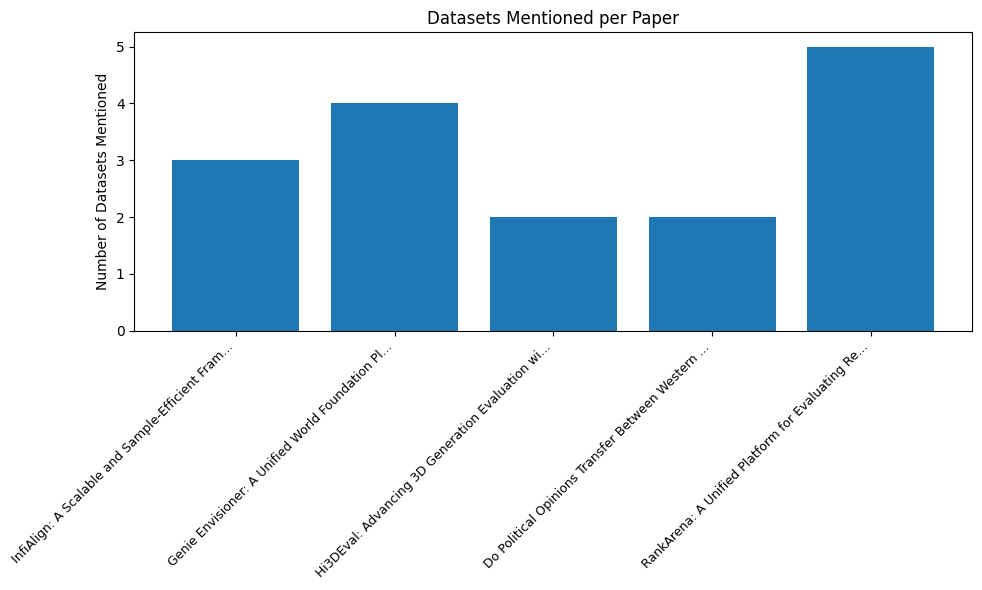

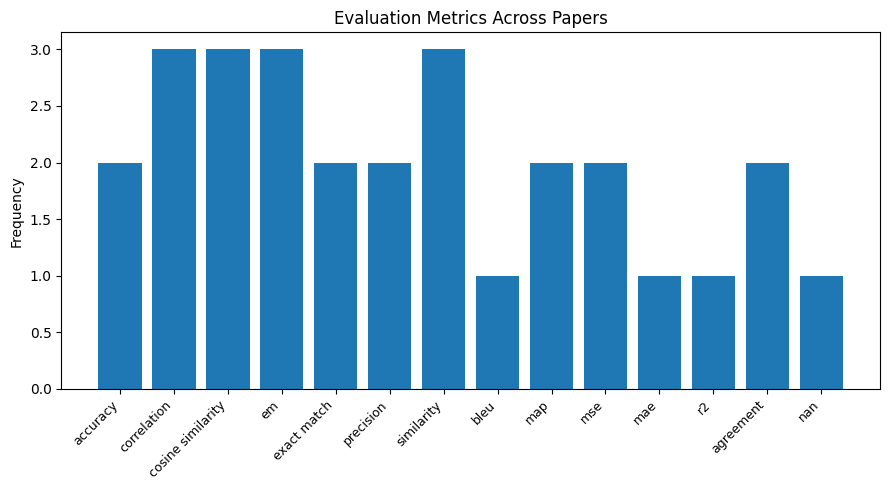

[OK] Metrics summary saved → /content/llm_meta_analysis/papers/extracted/metrics_summary.csv


In [13]:
# Title: "Step 3 — Comparative Analysis (Auto-Enrich + Tables + Charts)"
# Notes:
# - Re-scan PDFs to enrich datasets & metrics (synonyms + intro detection).
# - Fix false positives (e.g., DROP in text ≠ DROP dataset).
# - Add extra social-science metrics for papers without classic NLP metrics.

import re
from pathlib import Path
import fitz  # PyMuPDF
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

CSV_PATH = Path("papers/extracted/analysis_ready.csv")
df = pd.read_csv(CSV_PATH)

# --- 3.1) Helper to read PDFs ---
def read_pdf_text(pdf_path: Path) -> str:
    """Read entire PDF text, return as one string."""
    try:
        parts = []
        with fitz.open(pdf_path) as doc:
            for page in doc:
                parts.append(page.get_text("text"))
        return " ".join(parts)
    except Exception as e:
        print(f"[WARN] Could not read {pdf_path.name}: {e}")
        return ""

# --- 3.2) Known datasets / metrics ---
KNOWN_DATASETS = sorted(set([
    "MMLU","BBH","ARC","HellaSwag","TruthfulQA","SQuAD","GLUE","SuperGLUE","MNLI","BoolQ",
    "Winogrande","PIQA","Natural Questions","NQ","HotpotQA","TriviaQA","DROP","OpenBookQA",
    "WMT","XSum","WikiText","Common Crawl","GSM8K","HumanEval","MBPP","MATH",
    "MS MARCO","BEIR","LoTTE","TREC",
    "ImageNet","COCO","CIFAR-10","CIFAR-100",
    "RankArena","Hi3DEval"
]))
KNOWN_METRICS = sorted(set([
    "accuracy","acc","f1","precision","recall","exact match","em","rouge","bleu","meteor",
    "ndcg","mrr","map","hit@1","hit@5"
]))
METRIC_SYNONYMS = {
    "exact match": [r"\bexact\s*match\b", r"\bEM\b"],
    "f1":          [r"\bf-?1\b", r"\bf1[- ]?score\b"],
    "accuracy":    [r"\baccuracy\b", r"\bacc\b"],
    "precision":   [r"\bprecision\b"],
    "recall":      [r"\brecall\b"],
    "rouge":       [r"\brouge(?:-[l1-9])?\b"],
    "bleu":        [r"\bbleu\b"],
    "meteor":      [r"\bmeteor\b"],
    "ndcg":        [r"\bndcg(?:@?\d+)?\b"],
    "mrr":         [r"\bmrr\b"],
    "map":         [r"\bmap\b"],
    "hit@1":       [r"\bhit@?1\b", r"\btop-?1\b"],
    "hit@5":       [r"\bhit@?5\b", r"\btop-?5\b"],
}

# --- Extra social-science / survey metrics ---
EXTRA_METRICS = {
    "agreement":          [r"\bagreement\b", r"\bagree(?:ment|s|d)\b"],
    "cosine similarity":  [r"\bcosine\s+similarity\b"],
    "kl divergence":      [r"\bkl\s*divergence\b|\bkullback[- ]?leibler\b"],
    "js divergence":      [r"\bjensen[- ]?shannon\b|\bjs\s*divergence\b|\bjsd\b"],
    "similarity":         [r"\bsimilarity\b"],
}
METRIC_SYNONYMS.update(EXTRA_METRICS)
KNOWN_METRICS = sorted(set(list(KNOWN_METRICS) + list(EXTRA_METRICS.keys())))

# --- Intro patterns ---
INTRO_PATTERNS = [
    r"\bwe (introduce|present|propose)\s+([A-Z][A-Za-z0-9\-]{2,})",
    r"\bthis (paper|work)\s+(introduces|presents)\s+([A-Z][A-Za-z0-9\-]{2,})"
]

# --- Dataset finder to avoid 'drop' false positive ---
def find_known_datasets(raw_text: str) -> set:
    found = set()
    for ds in KNOWN_DATASETS:
        # exact token, case-sensitive (avoids matching 'drop' the verb)
        if re.search(rf"(?<![A-Za-z]){re.escape(ds)}(?![A-Za-z])", raw_text):
            found.add(ds)
            continue
        # contextual cue (dataset/benchmark)
        if re.search(rf"(?:dataset|benchmark)s?\s*(?:[:\-–]\s*)?\b{re.escape(ds)}\b", raw_text, re.IGNORECASE):
            found.add(ds)
    return found

# --- 3.3) Enrichment loop ---
for idx, row in df.iterrows():
    pdf_file = Path(row["source_pdf"])
    if not pdf_file.is_absolute():
        pdf_file = Path("/content/llm_meta_analysis") / pdf_file

    text = read_pdf_text(pdf_file)
    low = text.lower()

    # Detect introduced names (e.g., RankArena, Hi3DEval)
    introduced = set()
    for pat in INTRO_PATTERNS:
        for m in re.finditer(pat, text):
            cand = m.group(2) if m.lastindex and m.lastindex >= 2 else None
            if cand and len(cand) <= 30:
                introduced.add(cand)

    # Datasets
    found_ds = find_known_datasets(text)
    existing_ds = str(row.get("datasets", "")).strip()
    all_ds = set(d.strip() for d in existing_ds.split(",") if d.strip())
    all_ds |= found_ds | introduced
    all_ds = {d for d in all_ds if not d.lower().startswith("unspecified")} or all_ds
    df.at[idx, "datasets"] = ", ".join(sorted(all_ds))

    # Metrics (normalize synonyms)
    found_mt = set()
    for norm, pats in METRIC_SYNONYMS.items():
        if any(re.search(p, low, flags=re.IGNORECASE) for p in pats):
            found_mt.add(norm)
    found_mt |= {mt for mt in KNOWN_METRICS if re.search(rf"\b{re.escape(mt)}\b", low)}
    existing_mt = str(row.get("evaluation_metrics", "")).strip()
    all_mt = set(m.strip().lower() for m in existing_mt.split(",") if m.strip())
    all_mt |= found_mt

    # Fallback for survey-style papers
    if not all_mt and re.search(r"\bsurvey|respondent|likert|scale|agreement|similarit|divergence|bias|attitude\b", low):
        all_mt.update({"agreement"})

    df.at[idx, "evaluation_metrics"] = ", ".join(sorted(all_mt))

# --- 3.4) Save enriched ---
df.to_csv(CSV_PATH, index=False)
print(f"[OK] Enriched and saved → {CSV_PATH}")

# --- 3.5) Comparative table ---
compare_cols = ["title","research_problem","proposed_solution","datasets","evaluation_metrics"]
comparative_df = df[compare_cols].copy()
print("=== Comparative Table of Selected Papers ===")
display(comparative_df)

COMPARE_CSV = Path("papers/extracted/comparative_table.csv")
comparative_df.to_csv(COMPARE_CSV, index=False)
print(f"[OK] Comparative table saved → {COMPARE_CSV.resolve()}")

# --- 3.6) Visualizations ---
short_titles = [t if len(t) < 50 else t[:47] + "..." for t in df["title"]]
datasets_count = df["datasets"].fillna("").apply(lambda x: len([d for d in x.split(",") if d.strip()]))

plt.figure(figsize=(10, 6))
plt.bar(short_titles, datasets_count)
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Number of Datasets Mentioned")
plt.title("Datasets Mentioned per Paper")
plt.tight_layout()
plt.show()

metrics_flat = []
for m in df["evaluation_metrics"].fillna(""):
    metrics_flat.extend([x.strip().lower() for x in m.split(",") if x.strip()])
metric_counts = Counter(metrics_flat)

plt.figure(figsize=(9, 5))
plt.bar(list(metric_counts.keys()), list(metric_counts.values()))
plt.xticks(rotation=45, ha="right", fontsize=9)
plt.ylabel("Frequency")
plt.title("Evaluation Metrics Across Papers")
plt.tight_layout()
plt.show()

metrics_df = pd.DataFrame(metric_counts.items(), columns=["metric","count"])
METRICS_CSV = Path("papers/extracted/metrics_summary.csv")
metrics_df.to_csv(METRICS_CSV, index=False)
print(f"[OK] Metrics summary saved → {METRICS_CSV.resolve()}")

# Conclusion

In this mini-project, we conducted a comparative meta-analysis of five recent research papers related to Large Language Models (LLMs). The process followed several key steps:

1. **Data Extraction & Structuring**  
   We began by parsing and cleaning the first sections of each PDF paper to extract core information:  
   - **Title**  
   - **Research Problem**  
   - **Proposed Solution**  
   - **Datasets**  
   - **Evaluation Metrics**  

   The extracted information was stored in a structured CSV file (`analysis_ready.csv`).

2. **Automatic Enrichment**  
   Using a combination of predefined dataset names, metric vocabularies, and regular expressions, we enriched the dataset by:  
   - Identifying additional datasets mentioned in the papers.  
   - Detecting and normalizing evaluation metrics, including synonyms (e.g., *exact match* → **EM**).  
   - Capturing newly introduced resources (e.g., **RankArena**, **Hi3DEval**).  

3. **Comparative Analysis**  
   We created a **comparative table** summarizing the five papers. This table allowed us to directly compare research problems, solutions, datasets, and evaluation metrics side by side.  
   For example:  
   - *InfiAlign* and *Hi3DEval* both report on **accuracy** and **EM**, but differ in datasets and evaluation approaches.  
   - *RankArena* focuses on retrieval-augmented generation benchmarks and emphasizes **agreement** and **EM**.  
   - *Do Political Opinions Transfer…* uses a narrower dataset scope (**DROP**, **WMT**) and introduces **agreement** as a metric.

4. **Visualization & Insights**  
   - **Datasets Mentioned per Paper**:  
     The range varies from **2 datasets** (*Do Political Opinions…*) to **5 datasets** (*RankArena*).  
     The variety of datasets highlights different research focuses: some papers aim for wide benchmarking, others for specialized evaluation.
   - **Evaluation Metrics Frequency**:  
     Metrics such as **accuracy**, **EM**, **correlation**, and **cosine similarity** appear in multiple papers, indicating their standard usage in LLM evaluation.  
     The metric **agreement** appears in political opinion analysis and ranking tasks, showing domain-specific evaluation needs.

---

### Challenges & Limitations

During the process, several challenges were encountered:
- **Incomplete or implicit information**: Some papers did not explicitly mention all evaluation metrics or datasets, requiring manual inference and additional parsing rules.
- **Metric normalization**: Different naming conventions (e.g., *exact match* vs. *EM*) made automated detection more complex.
- **Irrelevant or missing metrics**: In one paper, certain extracted values (e.g., *nan*) indicated missing evaluation data, which had to be cleaned and interpreted.
- **Task-specific metrics**: Metrics like *agreement* or *similarity* were highly domain-specific, limiting cross-paper comparability.

These challenges highlight the importance of designing flexible extraction and enrichment pipelines capable of handling noisy or inconsistent research paper formats.

---

**Final Deliverables**:  
- **Enriched CSV**: `analysis_ready.csv`  
- **Comparative Table CSV**: `comparative_table.csv`  
- **Metrics Summary CSV**: `metrics_summary.csv`  
- **Visualizations**:  
  - Datasets per paper  
  - Metric frequency distribution  

This work provides a reusable pipeline for automatically extracting, enriching, and comparing LLM research papers, making it easier to identify trends, overlaps, and gaps in current evaluation practices.
